## CVEP pipeline

---
By: Jorge Sanmartin Martinez (s1150007), Paul Verhoeven (s1086755), Radovan Vodila (s1143934), and Thomas Kooiman (s1018394)

## 0. handle imports

In [ ]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import h5py
import mne
from scipy.io import loadmat


## 1. Load the dataset

### A. Load the online participant data

The traintrials data is of shape (trials x samples x channels) (THERE'S AN ERROR IN THE README). 31.5 seconds long with a sampling frequency of 180 Hz (which gives us 5670 samples).

Our final dataset consists of (2900 trials x 5670 samples x 8 channels)

Our final dataset in (trials x samples x channels):	 (2900, 5670, 8)
Our labels in (trials x label):	 (2900, 1)


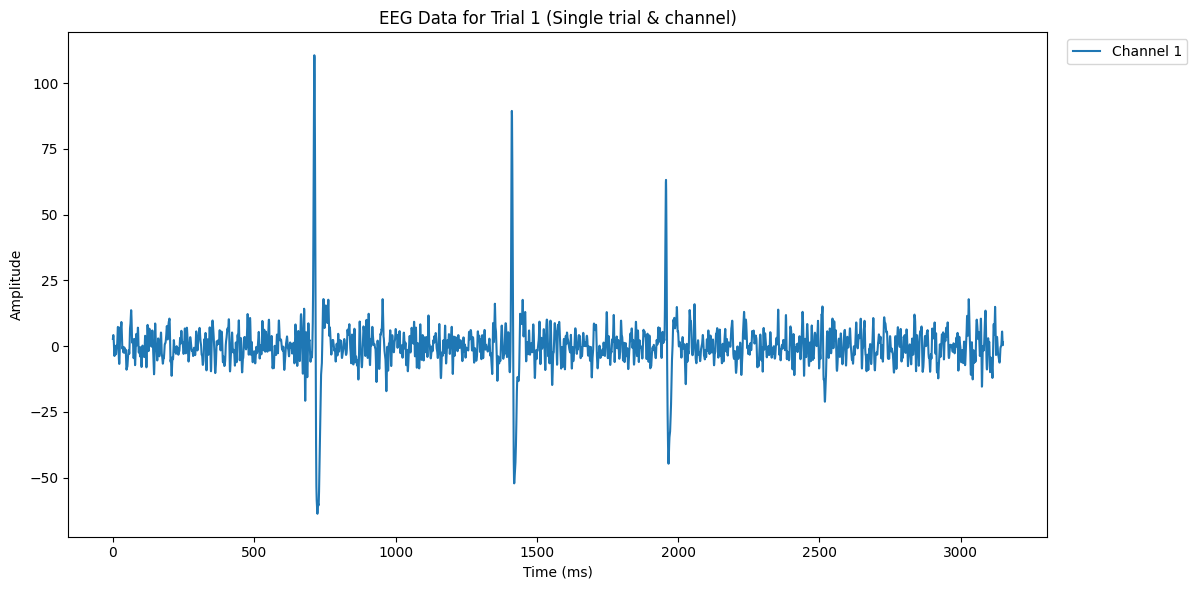

In [31]:
data_list = []
labels_list = []

for subject in range(1, 30):  # Exclude subject 30 for testing
    dataset_folder = Path("dataset") / f"sub-{subject:02}"
    blocks = dataset_folder.glob("block_*")
    for b in blocks:
        labels_file = b / "trainlabels.mat"
        data_file = b / "traintrials.mat"
        
        with h5py.File(data_file, 'r') as d_file:
            data_block = d_file['v'][:]

        with h5py.File(labels_file, 'r') as l_file:
            labels_block = l_file['v'][:]        

        data_list.append(data_block)
        labels_list.append(labels_block)

        
        

# NumPy array our data and labels
data = np.concatenate(data_list, axis=0) 
labels = np.concatenate(labels_list, axis=0)  

# Print the shapes
print("Our final dataset in (trials x samples x channels):\t",data.shape)
print("Our labels in (trials x label):\t",labels.shape)


# A nice plot for single trial and channel for a quick visualisation
plt.figure(figsize=(12, 6))
x = np.arange(0, 3150, 1/1.8)
plt.plot(x, data[0, :, 0], label=f'Channel 1')
plt.title('EEG Data for Trial 1 (Single trial & channel)')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.0), ncol=1)
plt.tight_layout()
plt.show()


### B. Load the codes file 
for our dataset `mgold_61_6521_flip_balanced_29.mat` was used. The shape of our codes is 126 x 20 for bits x codes. Note, these are sampled at 60 Hz. And thus require upsampling to match our datasets sample rate of 180hz

Original code shape: (126, 29)
Upsampled codes shape: (378, 29)


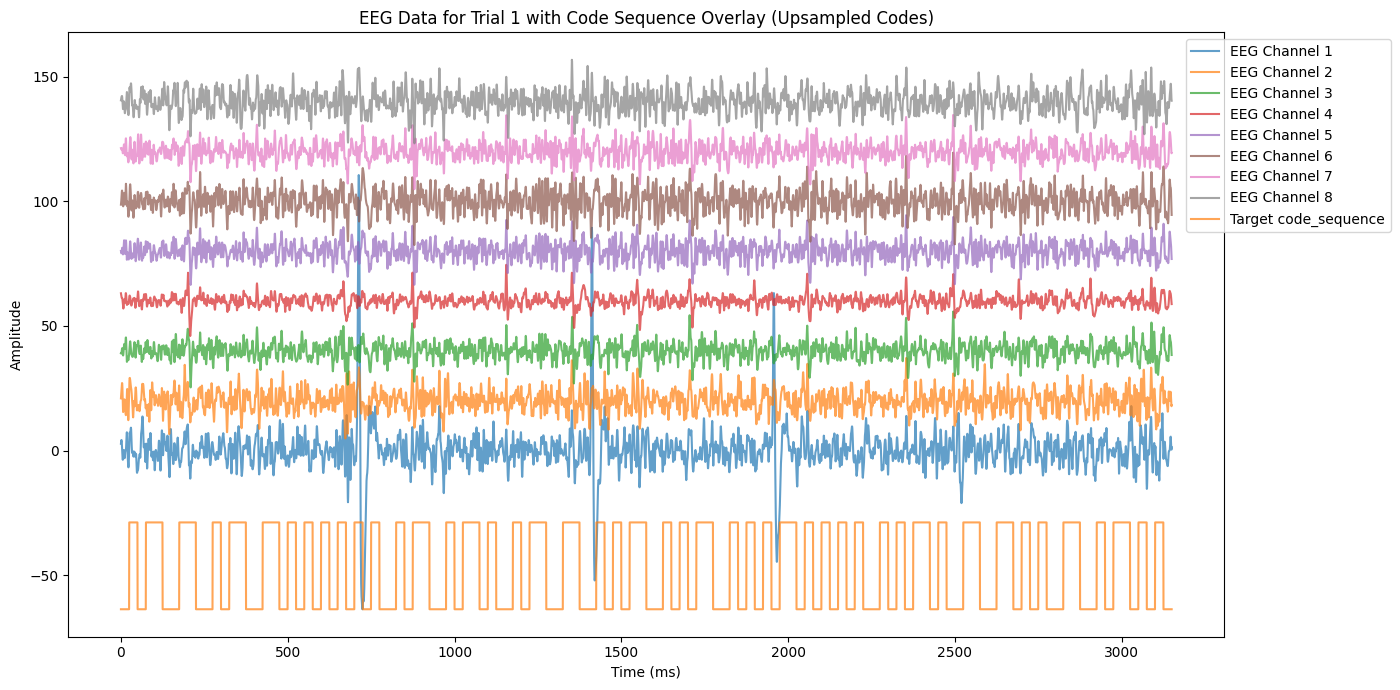

In [ ]:
# Load the codes_file
code_file = Path("resources") / "mgold_61_6521_flip_balanced_29.mat"
codes = loadmat(code_file)['codes'][:]

# Upsample all codes from 60 Hz to 180 Hz (repeat each bit 3 times)
codes_upsampled = np.repeat(codes, 3, axis=0)
print("Original code shape:", codes.shape)
print("Upsampled codes shape:", codes_upsampled.shape)


# Now to vizualize a single trial, channel and its target code. To get an understanding of what the data looks like in its full glory.
plt.figure(figsize=(14, 7))

for ch in range(data.shape[2]):
    plt.plot(x, data[0, :, ch]+20*ch, label=f'EEG Channel {ch+1}', alpha=0.7) # NOTE: I off-set the eeg data here to make it more readable.
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.0), ncol=1)

# Get the code sequence for the first trial and upsample to match EEG length
code_idx = int(labels[0, 0]) - 1
code_seq_upsampled = codes_upsampled[:, code_idx]

# Repeat each code bit further if needed to match EEG sample count
repeat_factor = int(np.ceil(data.shape[1] / code_seq_upsampled.shape[0]))
code_final = np.repeat(code_seq_upsampled, repeat_factor)[:data.shape[1]]

# Scale and offset code for visualization (courtesy of chatGPT)
code_plot = code_final * (np.max(data[0, :, 0]) - np.min(data[0, :, 0])) * 0.2 + np.min(data[0, :, 0])

plt.plot(x, code_plot, label='Target code_sequence', color='tab:orange', alpha=0.7)
plt.title('EEG Data for Trial 1 with Code Sequence Overlay (Upsampled Codes)')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.0), ncol=1)
plt.tight_layout()
plt.show()